In [318]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read raw data
df_raw = pd.read_csv("./datasets/20A_02.CSV")
df_raw = df_raw.rename(columns = {
    "in s": "t",
    "C1 in V": "Va",
    "C2 in A": "Ia",
    "C3 in V": "n"
})
df_raw

,t,Va,Ia,n
0,-0.024200,0.016113,-0.317383,4.705860
1,-0.024200,-0.042480,-0.122070,4.686330
2,-0.024199,-0.013184,-0.122070,4.647270
3,-0.024199,0.016113,0.024414,4.705860
4,-0.024199,0.001465,-0.170898,4.744920
...,...,...,...,...
999995,0.215799,12.086400,1.293950,0.018359
999996,0.215799,12.071800,1.489260,4.725390
999997,0.215799,12.057100,1.245120,4.647270
999998,0.215800,12.013200,1.293950,4.705860


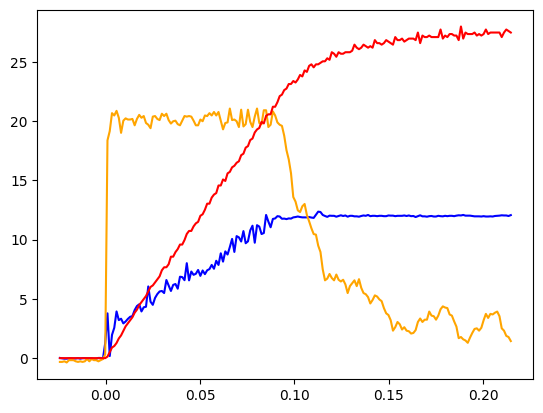

,t,Va,Ia,Wm
0,-0.0242,0.016113,-0.317383,0.000000
5000,-0.0230,-0.013184,-0.317383,0.000000
10000,-0.0218,-0.042480,-0.268555,0.000000
15000,-0.0206,-0.042480,-0.366211,0.000000
20000,-0.0194,-0.013184,-0.170898,0.000000
...,...,...,...,...
975000,0.2098,12.057100,2.514650,542.006545
980000,0.2110,12.042500,2.319340,549.676449
985000,0.2122,12.042500,1.879880,554.789718
990000,0.2134,11.998500,1.782230,552.233084


In [319]:
from dcmotor import get_rising_edges

# Downsampling
df_downsampled = pd.DataFrame()

num_steps = 2048
start = True
time_step_raw = df_raw["t"].diff().iloc[1]
batch_size = 5000
time_step = time_step_raw * batch_size

df_downsampled["t"] = df_raw["t"].iloc[::batch_size]
df_downsampled["Va"] = df_raw["Va"].iloc[::batch_size]
df_downsampled["Ia"] = df_raw["Ia"].iloc[::batch_size]
df_downsampled["Wm"] = np.array(get_rising_edges(df_raw["n"].array, 2048, 4, time_step_raw, batch_size)) * np.pi * 2

plt.plot(df_downsampled["t"], df_downsampled["Va"], c="blue")
plt.plot(df_downsampled["t"], df_downsampled["Ia"], c="orange")
plt.plot(df_downsampled["t"], df_downsampled["Wm"]/20, c="red")
plt.show()
df_downsampled

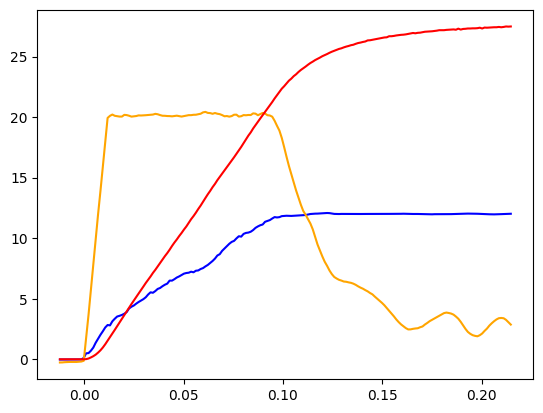

,t,Va,Ia,Wm
50000,-0.0122,-0.021973,-0.263672,0.000000
55000,-0.0110,-0.020508,-0.258789,0.000000
60000,-0.0098,-0.017578,-0.239258,0.000000
65000,-0.0086,-0.014648,-0.229492,0.000000
70000,-0.0074,-0.014648,-0.219727,0.000000
...,...,...,...,...
975000,0.2098,11.986810,3.413085,548.398132
980000,0.2110,11.995600,3.388671,548.909459
985000,0.2122,12.001460,3.256835,549.676449
990000,0.2134,12.005850,3.061523,549.420786


In [320]:
# Low pass filtering
df_filtered = pd.DataFrame()

rolling_width = 10
start_offset = 0

df_filtered["t"] = df_downsampled["t"].iloc[rolling_width+start_offset:]
df_filtered["Va"] = df_downsampled["Va"].rolling(rolling_width).mean().iloc[rolling_width+start_offset:]
df_filtered["Ia"] = df_downsampled["Ia"].rolling(rolling_width).mean().iloc[rolling_width+start_offset:]
df_filtered["Wm"] = df_downsampled["Wm"].rolling(rolling_width).mean().iloc[rolling_width+start_offset:]

plt.plot(df_filtered["t"], df_filtered["Va"], c="blue")
plt.plot(df_filtered["t"], df_filtered["Ia"], c="orange")
plt.plot(df_filtered["t"], df_filtered["Wm"]/20, c="red")
plt.show()
df_filtered

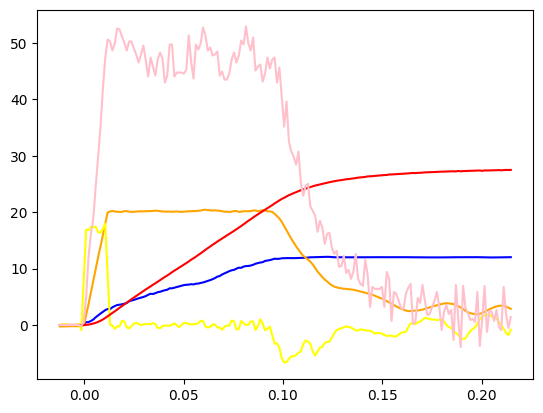

,t,Va,Ia,Wm,dIa,dWm
50000,-0.0122,-0.021973,-0.263672,0.000000,1.017244,0.000000
55000,-0.0110,-0.020508,-0.258789,0.000000,11.189789,0.000000
60000,-0.0098,-0.017578,-0.239258,0.000000,13.224290,0.000000
65000,-0.0086,-0.014648,-0.229492,0.000000,8.137985,0.000000
70000,-0.0074,-0.014648,-0.219727,0.000000,4.068990,0.000000
...,...,...,...,...,...,...
975000,0.2098,11.986810,3.413085,548.398132,-0.339167,-88.772036
980000,0.2110,11.995600,3.388671,548.909459,-63.747847,674.667476
985000,0.2122,12.001460,3.256835,549.676449,-143.771528,195.298480
990000,0.2134,12.005850,3.061523,549.420786,-180.731389,-53.263222


In [321]:
from dcmotor import five_point_stencil

# Get derivatives
df = pd.DataFrame(df_filtered)
df["dIa"] = five_point_stencil(df_filtered["Ia"].array, time_step)
df["dWm"] = five_point_stencil(df_filtered["Wm"].array, time_step)

plt.plot(df["t"], df["Va"], c="blue")
plt.plot(df["t"], df["Ia"], c="orange")
plt.plot(df["t"], df["dIa"]/100, c="yellow")
plt.plot(df["t"], df["Wm"]/20, c="red")
plt.plot(df["t"], df["dWm"]/100, c="pink")
plt.show()
df

In [327]:
# Linear regression

# Circuit Equation
# Va = i*Ra + L*di/dt + Ke*w
# Tm = Ke*i = TL + Jm*dw/dt + Bm*w

Ra = 0.091
Ke = 18.803 / 1000
TL = 0

t = np.array(df["t"].array)

Va = np.array(df["Va"].array)

Ia = np.array(df["Ia"].array)
dIa = np.array(df["dIa"].array)

Wm = np.array(df["Wm"].array)
dWm = np.array(df["dWm"].array)

In [328]:
R_t = np.zeros((3,3))
h_t = np.zeros((3,1))
lambda_t = 0
theta_t = np.zeros((3,1))
S0 = 1

# Circuit equation
# Va - Ke*w = i*Ra + L*di/dt 

for k in range(len(t)):
    y = np.vstack([Va[k]])
    X = np.array([
        [Ia[k], dIa[k], Wm[k]],
    ])
    R_t = X.T @ X + lambda_t * R_t
    h_t = X.T @ y + lambda_t * h_t

    if np.linalg.det(R_t) != 0:
        P_t = np.linalg.inv(R_t)
        theta_t = P_t @ h_t
        sigma = (y - X @ theta_t).sum()
        lambda_t = 1 - (sigma ** 2) / (S0 * (1 + X @ P_t @ X.T))

print("Batch size:", batch_size)
theta = theta_t
Ra_pred, La_pred, Ke_pred = theta.T[0][:3]

print("Ra", Ra_pred)
print("La", La_pred)
print("Ke", Ke_pred)

Batch size: 5000
Ra 0.12319223247418015
La -0.00016640608413271001
Ke 0.021422049720637222


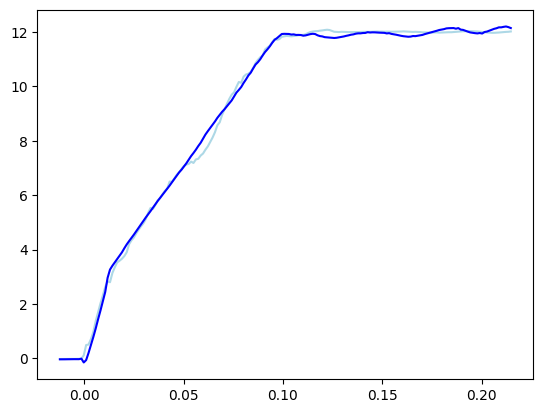

In [329]:
# Equations
# Va = i*Ra + L*di/dt + Ke*w
# Tm = Kt*i = TL + Jm*dw/dt + Bm*w
# TL = Kt*i - Jm*dw/dt - Bm*w

Va_pred = Ia*Ra_pred + La_pred*dIa + Ke_pred*Wm

plt.plot(t, Va, c="lightblue")
plt.plot(t, Va_pred, c="blue")
plt.show()

In [330]:
R_t = np.zeros((2,2))
h_t = np.zeros((2,1))
lambda_t = 0
theta_t = np.zeros((2,1))
S0 = 1

# Torque Equation
# Ke*i - TL = Jm*dw/dt + Bm*w

for k in range(len(t)):
    y = np.vstack([Ke_pred * Ia[k] - TL])
    X = np.array([
        [dWm[k], Wm[k]],
    ])
    R_t = X.T @ X + lambda_t * R_t
    h_t = X.T @ y + lambda_t * h_t

    if np.linalg.det(R_t) != 0:
        P_t = np.linalg.inv(R_t)
        theta_t = P_t @ h_t
        sigma = (y - X @ theta_t).sum()
        lambda_t = 1 - (sigma ** 2) / (S0 * (1 + X @ P_t @ X.T))

print("Batch size:", batch_size)
theta = theta_t
Jm_pred, Bm_pred = theta.T[0][:2]

print("Jm", Jm_pred)
print("Bm", Bm_pred)

Batch size: 5000
Jm 8.613163176216291e-05
Bm 8.27549975146489e-05


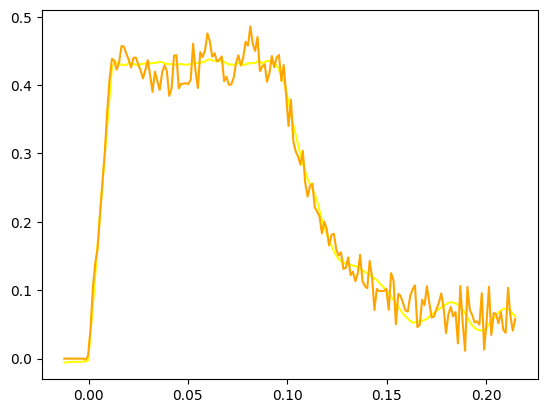

In [333]:
# Equations
# Va = i*Ra + L*di/dt + Ke*w
# Tm = Kt*i = TL + Jm*dw/dt + Bm*w
# TL = Kt*i - Jm*dw/dt - Bm*w

Tm = Ke_pred * Ia
Tm_pred = TL + Jm_pred*dWm + Bm_pred*Wm

plt.plot(t, Tm, c="yellow")
plt.plot(t, Tm_pred, c="orange")
plt.show()